# Extended Kalman Filter (EKF) for a Differential Drive Robot

This notebook implements and explains an **Extended Kalman Filter (EKF)** for a simple robot whose state is:


\begin{bmatrix}
x \\
y \\
\text{yaw}
\end{bmatrix}


We’ll go step-by-step through:
1. The **motion model (prediction)**  
2. The **measurement update**  
3. A simple **simulation example**


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt


## The EKF class

The EKF maintains two main things:
- **State estimate**: our belief about where the robot is (`x`)
- **Covariance matrix (P)**: uncertainty in that belief

We define:
- `Q`: process noise covariance — uncertainty in the motion model  
- `R`: measurement noise covariance — uncertainty in the sensors


In [2]:
class EKF:
    def __init__(self, dt=0.1,
                 Q=np.diag([0.02, 0.02, np.deg2rad(2.0)])**2,
                 R=np.diag([0.5, 0.5, np.deg2rad(5.0)])**2):
        """Extended Kalman Filter for a differential-drive robot."""
        self.dt = dt
        self.Q = Q
        self.R = R
        self.x = np.zeros(3)  # state: [x, y, yaw]
        self.P = np.diag([1.0, 1.0, np.deg2rad(10)**2])  # initial uncertainty

    # -------------------------------------------------------------
    def predict(self, v, w):
        """Predict next state using motion model and control inputs."""
        theta = self.x[2]
        dt = self.dt

        # Motion model
        self.x[0] += v * math.cos(theta) * dt
        self.x[1] += v * math.sin(theta) * dt
        self.x[2] += w * dt
        self.x[2] = self._wrap_angle(self.x[2])

        # Jacobian wrt state
        F = np.array([
            [1, 0, -v * math.sin(theta) * dt],
            [0, 1,  v * math.cos(theta) * dt],
            [0, 0,  1]
        ])

        # Covariance prediction
        self.P = F @ self.P @ F.T + self.Q
        self.P = 0.5 * (self.P + self.P.T)  # enforce symmetry

        return self.x.copy(), self.P.copy()

    # -------------------------------------------------------------
    def update(self, z):
        """Update step given a noisy measurement z = [x, y, yaw]."""
        H = np.eye(3)
        y = z - self.x
        y[2] = self._wrap_angle(y[2])

        S = H @ self.P @ H.T + self.R
        K = self.P @ H.T @ np.linalg.inv(S)

        self.x = self.x + K @ y
        self.x[2] = self._wrap_angle(self.x[2])

        self.P = (np.eye(3) - K @ H) @ self.P
        self.P = 0.5 * (self.P + self.P.T)

        return self.x.copy(), self.P.copy()

    # -------------------------------------------------------------
    @staticmethod
    def _wrap_angle(a):
        return (a + np.pi) % (2 * np.pi) - np.pi


## EKF equations overview

### 1. Prediction step

We use the robot’s motion model to predict its next state:

$$
\begin{bmatrix}
x' \\
y' \\
\text{yaw}'
\end{bmatrix}
=
f\!\left(
\begin{bmatrix}
x \\
y \\
\text{yaw}
\end{bmatrix},
u
\right)
=
\begin{bmatrix}
x + v \cos(\theta)\, \Delta t \\
y + v \sin(\theta)\, \Delta t \\
\theta + \omega\, \Delta t
\end{bmatrix}
$$



and update uncertainty:

$$
P' = F\,P\,F^\top + Q
$$


Here,  
- \( F \) is the **Jacobian of the motion model**  
$$
F =
\begin{bmatrix}
1 & 0 & -v \sin(\theta)\, \Delta t \\
0 & 1 & \;\;v \cos(\theta)\, \Delta t \\
0 & 0 & 1
\end{bmatrix}
$$


- \( Q \) is **process noise** (uncertainty in motion)

### 2. Update step
We correct the prediction using a measurement \( z \):
$$
y = z - h(x')
$$

$$
S = H\,P'\,H^\top + R
$$

$$
K = P'\,H^\top\,S^{-1}
$$

$$
x = x' + K\,y
$$

$$
P = (I - K\,H)\,P'
$$

Where:
- \( K \) = Kalman gain — how much to trust measurement vs prediction  
- \( R \) = measurement noise  
- \( H \) = measurement Jacobian (here, identity because we measure directly \$ (x,\, y,\, \text{yaw}) $



In [3]:
ekf = EKF(dt=0.1)
v_true = 1.0  # m/s
w_true = 0.1  # rad/s

xs, ys = [], []
zs_x, zs_y = [], []

for t in np.arange(0, 10, ekf.dt):
    ekf.predict(v_true, w_true)
    z = ekf.x + np.random.multivariate_normal(mean=[0, 0, 0], cov=ekf.R)
    ekf.update(z)

    xs.append(ekf.x.copy())
    zs_x.append(z[0])
    zs_y.append(z[1])

xs = np.array(xs)


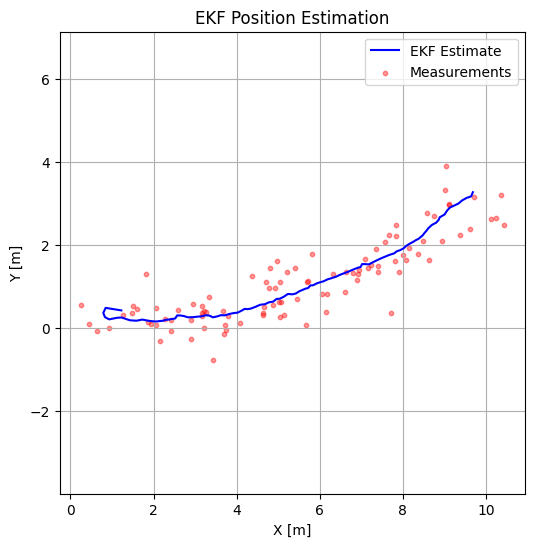

In [4]:
plt.figure(figsize=(6, 6))
plt.plot(xs[:, 0], xs[:, 1], 'b-', label="EKF Estimate")
plt.scatter(zs_x, zs_y, s=10, c='r', alpha=0.4, label="Measurements")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("EKF Position Estimation")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

## Interpretation of the results

- **Red dots**: noisy measurements from sensors  
- **Blue line**: EKF’s filtered estimate of the robot’s trajectory

The EKF effectively **smooths out the noise** and gives a consistent estimate of the robot’s path over time.
You can experiment by:
- Increasing measurement noise `R`
- Increasing process noise `Q`
- Changing `v_true` and `w_true`
